In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class ParquetPacketDataset(Dataset):
    def __init__(self, file_paths, label_column='Label', transform=None, sample_fraction=0.5, include_labels=None):
        self.file_paths = file_paths
        self.label_column = label_column
        self.transform = transform
        self.sample_index = []
        self.partial_dataframes = []  # Hold partial sampled data to avoid reloading

        for file_idx, path in enumerate(file_paths):
            try:
                df = pd.read_parquet(path)
                if include_labels:
                    df = df[df[label_column].isin(include_labels)]

                if len(df) == 0:
                    continue

                # Sample a fraction to avoid OOM
                df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
                self.partial_dataframes.append(df)
                self.sample_index.extend([(file_idx, i) for i in range(len(df))])
            except Exception as e:
                print(f"Error reading {path}: {e}")

        if not self.sample_index:
            raise ValueError("No samples collected. Check your parquet files or sample_fraction.")
        print(f"✅ Total samples collected: {len(self.sample_index)}")

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx):
        file_idx, row_idx = self.sample_index[idx]
        row = self.partial_dataframes[file_idx].iloc[row_idx]

        label = row[self.label_column]
        features = row.drop(self.label_column).values.astype('float32')
        features = torch.tensor(features)

        if self.transform:
            features = self.transform(features)

        # Convert label to 0 (benign) or 1 (anomaly)
        label_tensor = torch.tensor(0 if label == 'Benign' else 1, dtype=torch.long)

        return features, label_tensor


In [ ]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# List all parquet files
data_dir = 'archive'
parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Train on only benign samples
train_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=1,
    include_labels=["Benign"]  # Train on only benign
)

# Test on mixed (benign + anomalous) samples 
test_dataset = ParquetPacketDataset(
    parquet_files,
    sample_fraction=0.2  # Set to 0.2 to save memory
)

# Extract all features from benign training set
def extract_features(dataset):
    features_list = []
    for i in range(len(dataset)):
        features, _ = dataset[i]
        features_list.append(features.numpy())
    return np.array(features_list)

# Compute scaler on training data
X_train = extract_features(train_dataset)
scaler = StandardScaler()
scaler.fit(X_train)

# Define a transform using the fitted scaler
def standardize_tensor(tensor):
    np_arr = tensor.numpy()
    scaled_arr = scaler.transform([np_arr])[0]
    return torch.tensor(scaled_arr, dtype=torch.float32)

# Reinitialize datasets with transform
train_dataset.transform = standardize_tensor
test_dataset.transform = standardize_tensor

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)


✅ Total samples collected: 97831
✅ Total samples collected: 86275


In [ ]:
# Simple Autoencoder Structure
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32) # Latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
# Training Loop for Simple Autoencoder
def train_autoencoder(model, dataloader, epochs=20, lr=1e-3, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    return model


In [ ]:
# Determine input dimension from one sample
sample_input, _ = train_dataset[0]
input_dim = sample_input.shape[0]

model = SimpleAutoencoder(input_dim=input_dim)
model = train_autoencoder(model, train_loader, epochs=20, lr=0.0003, device='cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/20 | Loss: 0.327724
Epoch 2/20 | Loss: 0.133040
Epoch 3/20 | Loss: 0.100866
Epoch 4/20 | Loss: 0.125033
Epoch 5/20 | Loss: 0.075796
Epoch 6/20 | Loss: 0.055255
Epoch 7/20 | Loss: 0.062745
Epoch 8/20 | Loss: 0.050735
Epoch 9/20 | Loss: 0.035969
Epoch 10/20 | Loss: 0.051628
Epoch 11/20 | Loss: 0.038527
Epoch 12/20 | Loss: 0.032372
Epoch 13/20 | Loss: 0.034657
Epoch 14/20 | Loss: 0.044165
Epoch 15/20 | Loss: 0.028193
Epoch 16/20 | Loss: 0.046324
Epoch 17/20 | Loss: 0.028656
Epoch 18/20 | Loss: 0.029657
Epoch 19/20 | Loss: 0.027523
Epoch 20/20 | Loss: 0.027614


In [ ]:
import torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt

# Initial Autoencoder Evaluation
def evaluate_autoencoder(model, test_loader, device):
    model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            errors = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    return all_errors, all_labels

In [ ]:
# ROC-AUC Curve
def plot_roc_auc(errors, labels):
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
    
    return thresholds, roc_auc


In [ ]:
# Utilizing F1-Scores and ROC-AUC to determine the best threshold
def find_best_threshold(errors, labels):
    precision, recall, thresholds = precision_recall_curve(labels, errors)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return best_threshold


In [ ]:
# Error Distribution Plot
def plot_error_distribution(errors, labels, threshold):
    errors = np.array(errors)
    labels = np.array(labels)

    print("Benign samples:", np.sum(labels == 0))
    print("Anomalous samples:", np.sum(labels == 1))

    bins = np.linspace(min(errors), max(errors), 100)
    
    plt.figure(figsize=(6, 4))
    plt.hist(errors[labels == 0], bins=bins, alpha=0.6, label='Benign')
    plt.hist(errors[labels == 1], bins=bins, alpha=0.6, label='Anomalous')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Error Distribution")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# Compile all evaluation functions
def evaluate_predictions(errors, labels, threshold):
    preds = (errors > threshold).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(labels, preds))

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Benign', 'Anomalous']))

    print("\nError Distribution")
    plot_error_distribution(errors, labels, threshold)

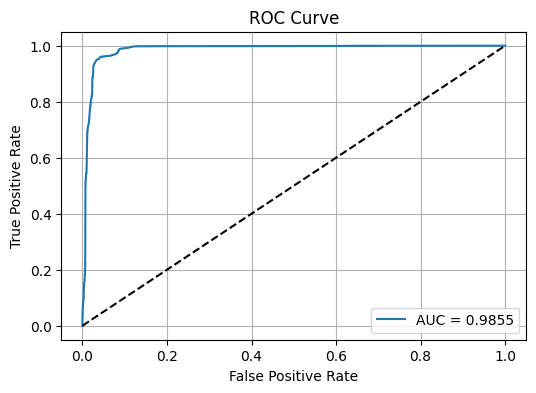

Best Threshold: 0.0202
Confusion Matrix:
[[17642  1772]
 [  702 66159]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.91      0.93     19414
   Anomalous       0.97      0.99      0.98     66861

    accuracy                           0.97     86275
   macro avg       0.97      0.95      0.96     86275
weighted avg       0.97      0.97      0.97     86275


Error Distribution
Benign samples: 19414
Anomalous samples: 66861


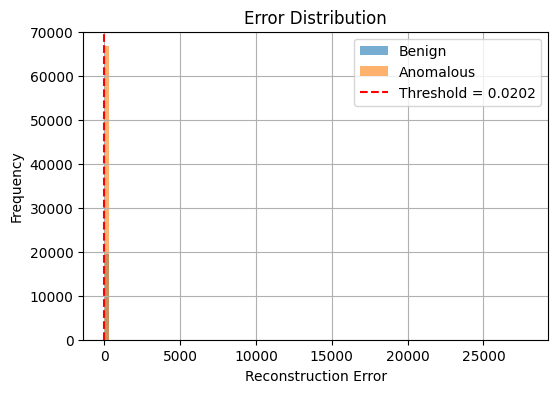

In [ ]:
# Evaluate
errors, labels = evaluate_autoencoder(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Find best threshold and show ROC/AUC
thresholds, roc_auc = plot_roc_auc(errors, labels)
best_threshold = find_best_threshold(errors, labels)
print(f"Best Threshold: {best_threshold:.4f}")

# Evaluate at best threshold
evaluate_predictions(errors, labels, best_threshold)


In [ ]:
# Save model state dictionary
torch.save(model.state_dict(), 'simple_autoencoder.pth')

In [ ]:
# Variational Autoencoder Structure
class VAE(nn.Module):
    def __init__(self, input_dim=77, hidden_dims=[128, 64], latent_dim=16):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[1], latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
# Beta Function for KL and Recon Loss Trade-off
def get_beta(epoch, max_beta=1.0, n_epochs=30):
    return min(max_beta, epoch / (n_epochs // 4))

In [ ]:
# VAE Loss Function; Incorporates Beta between Mu and Logvar
def vae_loss_function(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_loss = torch.mean(torch.sum(0.5 * (mu.pow(2) + logvar.exp() - 1 - logvar), dim=1))
    kl_loss = torch.clamp(kl_loss, max=10.0)
    
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

In [ ]:
# VAE Training Loop; Increments Beta for each epoch to assist the divergence in the loss function
def train_vae(model, dataloader, epochs=30, lr=1e-3, device='cpu', beta_start=0.0, beta_end=1.0):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = total_recon = total_kl = 0.0
        beta = beta_start + (beta_end - beta_start) * (epoch / epochs)

        for batch in dataloader:
            x, _ = batch
            x = x.to(device)

            recon, mu, logvar = model(x)
            loss, recon_loss, kl_loss = vae_loss_function(recon, x, mu, logvar, beta)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Recon Loss: {total_recon/len(dataloader):.6f}, "
              f"KL Loss: {total_kl/len(dataloader):.6f}, "
              f"Total Loss: {total_loss/len(dataloader):.6f}, "
              f"Beta: {beta:.4f}")
        
    return model


In [ ]:
# Train the model
sample_input, _ = train_dataset[0]
input_dim = sample_input.shape[0]

vae = VAE(input_dim=77, latent_dim=16)
vae = train_vae(vae, train_loader, epochs=30, lr=1e-4, beta_start=0.0, beta_end=0.01)

Epoch [1/30] - Recon Loss: 270.325056, KL Loss: 8.900808, Total Loss: 270.325056, Beta: 0.0000
Epoch [2/30] - Recon Loss: 0.252192, KL Loss: 10.000000, Total Loss: 0.255525, Beta: 0.0003
Epoch [3/30] - Recon Loss: 0.193399, KL Loss: 10.000000, Total Loss: 0.200065, Beta: 0.0007
Epoch [4/30] - Recon Loss: 0.156718, KL Loss: 10.000000, Total Loss: 0.166718, Beta: 0.0010
Epoch [5/30] - Recon Loss: 0.131848, KL Loss: 10.000000, Total Loss: 0.145182, Beta: 0.0013
Epoch [6/30] - Recon Loss: 0.099065, KL Loss: 10.000000, Total Loss: 0.115732, Beta: 0.0017
Epoch [7/30] - Recon Loss: 0.087231, KL Loss: 10.000000, Total Loss: 0.107231, Beta: 0.0020
Epoch [8/30] - Recon Loss: 0.075881, KL Loss: 10.000000, Total Loss: 0.099214, Beta: 0.0023
Epoch [9/30] - Recon Loss: 0.065560, KL Loss: 10.000000, Total Loss: 0.092226, Beta: 0.0027
Epoch [10/30] - Recon Loss: 0.060455, KL Loss: 10.000000, Total Loss: 0.090455, Beta: 0.0030
Epoch [11/30] - Recon Loss: 0.057169, KL Loss: 10.000000, Total Loss: 0.0905

In [ ]:
# Initial Evaluation Function
def evaluate_autoencoder(model, test_loader, device):
    model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)

            outputs = model(inputs)[0]

            errors = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    return all_errors, all_labels


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Custom Compiled Evaluation Function
def evaluate_autoencoder_with_metrics(model, test_loader, device):
    errors, labels = evaluate_autoencoder(model, test_loader, device)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Best threshold using Youden’s J statistic
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]
    print(f"\nBest Threshold: {best_threshold:.6f}")

    # Predict using threshold
    predictions = (errors > best_threshold).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(labels, predictions, digits=4))

    # Plot reconstruction error distribution
    benign_errors = errors[labels == 0]
    anomaly_errors = errors[labels == 1]

    bins = np.linspace(min(errors), max(errors), 100)

    plt.figure(figsize=(10, 5))
    plt.hist(benign_errors, bins=bins, alpha=0.6, label='Benign', color='green')
    plt.hist(anomaly_errors, bins=bins, alpha=0.6, label='Anomaly', color='red')
    plt.axvline(best_threshold, color='black', linestyle='--', label='Best Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.grid()
    plt.show()

    return errors, predictions, best_threshold


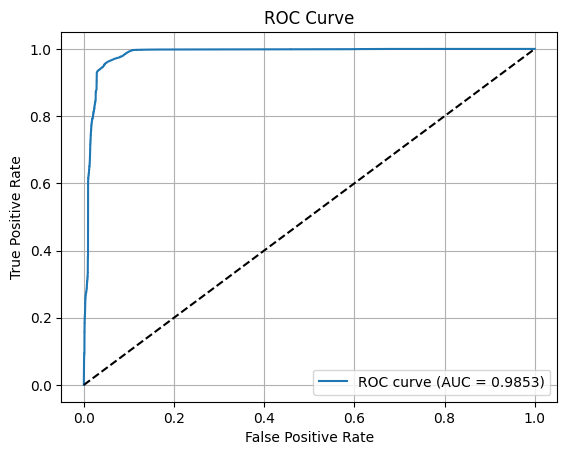


Best Threshold: 0.024603

Classification Report:
              precision    recall  f1-score   support

           0     0.8683    0.9512    0.9078     19414
           1     0.9854    0.9581    0.9716     66861

    accuracy                         0.9565     86275
   macro avg     0.9268    0.9546    0.9397     86275
weighted avg     0.9591    0.9565    0.9572     86275



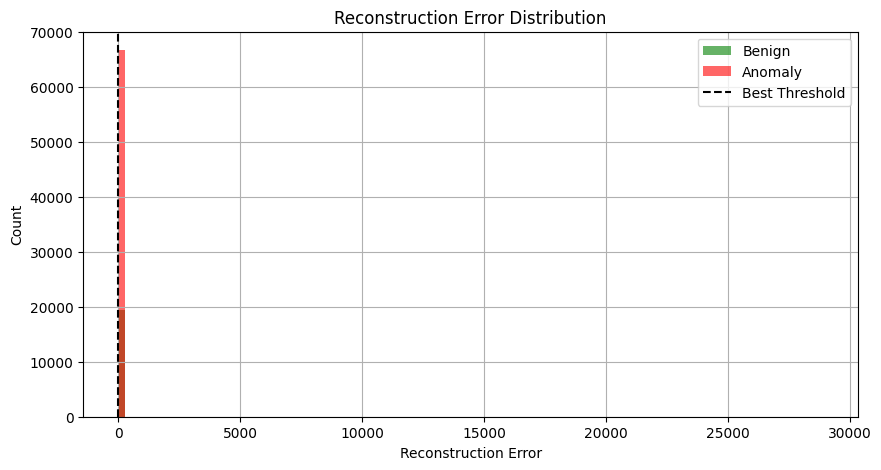

In [ ]:
# Evaluate VAE Model
errors, predictions, threshold = evaluate_autoencoder_with_metrics(vae, test_loader, "cpu")

In [ ]:
# Save model state dictionary
torch.save(vae.state_dict(), 'variational_autoencoder.pth')

In [ ]:
# DRAE Model Structure
class DeepRecurrentAutoencoder(nn.Module):
    def __init__(self, input_size=77, hidden_size=64, latent_size=32, num_layers=2):
        super(DeepRecurrentAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, bidirectional=True, dropout=0.2)
        
        self.fc_enc = nn.Linear(hidden_size * 2, latent_size)
        self.fc_dec = nn.Linear(latent_size, hidden_size * 2)
        
        self.decoder = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers,
                               batch_first=True, dropout=0.2)
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dim: [B, 1, 77]
        _, (h_n, _) = self.encoder(x)  # [num_layers * 2, B, hidden_size]
        h_last = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Concatenate directions [B, hidden_size*2]

        latent = self.fc_enc(h_last)  # [B, latent_size]
        dec_input = self.fc_dec(latent).unsqueeze(1).repeat(1, x.size(1), 1)  # [B, 1, hidden_size*2]
        
        dec_output, _ = self.decoder(dec_input)  # [B, 1, hidden_size]
        output = self.output_layer(dec_output)  # [B, 1, 77]
        return output.squeeze(1)  # [B, 77]


In [ ]:
# Training Loop for DRAE
def train_recurrent_autoencoder(model, train_loader, optimizer, criterion, device, epochs=30):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch}/{epochs}] - Loss: {avg_loss:.6f}")


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Compiled Evaluation Function
def evaluate_autoencoder(model, test_loader, device):
    model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            errors = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Best threshold using Youden’s J statistic
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    print(f"Best Threshold: {best_threshold:.4f}")

    predictions = (all_errors >= best_threshold).astype(int)
    print("Classification Report:\n", classification_report(all_labels, predictions))

    # Error distribution plot
    plt.hist(all_errors[all_labels == 0], bins=50, alpha=0.6, label="Benign")
    plt.hist(all_errors[all_labels == 1], bins=50, alpha=0.6, label="Anomalous")
    plt.axvline(x=best_threshold, color='r', linestyle='--', label='Threshold')
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return all_errors, all_labels, best_threshold


In [ ]:
# Define Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepRecurrentAutoencoder().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the Model
train_recurrent_autoencoder(model, train_loader, optimizer, criterion, device, epochs=30)

Epoch [1/100] - Loss: 0.414459
Epoch [2/100] - Loss: 0.301712
Epoch [3/100] - Loss: 0.262534
Epoch [4/100] - Loss: 0.238735
Epoch [5/100] - Loss: 0.220548
Epoch [6/100] - Loss: 0.207693
Epoch [7/100] - Loss: 0.199355
Epoch [8/100] - Loss: 0.194507
Epoch [9/100] - Loss: 0.186425
Epoch [10/100] - Loss: 0.181609
Epoch [11/100] - Loss: 0.176872
Epoch [12/100] - Loss: 0.173854
Epoch [13/100] - Loss: 0.169809
Epoch [14/100] - Loss: 0.168025
Epoch [15/100] - Loss: 0.165287
Epoch [16/100] - Loss: 0.160582
Epoch [17/100] - Loss: 0.159125
Epoch [18/100] - Loss: 0.156388
Epoch [19/100] - Loss: 0.153817
Epoch [20/100] - Loss: 0.151819
Epoch [21/100] - Loss: 0.149559
Epoch [22/100] - Loss: 0.147319
Epoch [23/100] - Loss: 0.145621
Epoch [24/100] - Loss: 0.142928
Epoch [25/100] - Loss: 0.142304
Epoch [26/100] - Loss: 0.141997
Epoch [27/100] - Loss: 0.140414
Epoch [28/100] - Loss: 0.138677
Epoch [29/100] - Loss: 0.136879
Epoch [30/100] - Loss: 0.135238
Epoch [31/100] - Loss: 0.135661
Epoch [32/100] - 

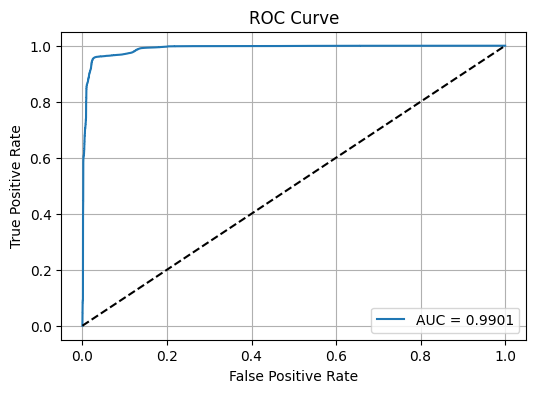

Best Threshold: 0.0716
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     19414
           1       0.99      0.96      0.97     66861

    accuracy                           0.96     86275
   macro avg       0.93      0.96      0.95     86275
weighted avg       0.96      0.96      0.96     86275



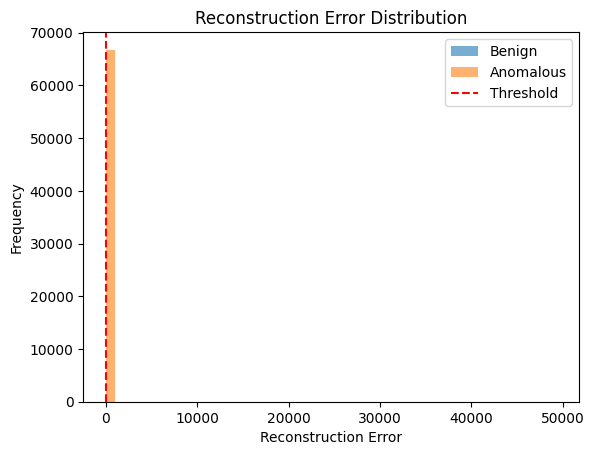

In [ ]:
# Evaluate the model
errors, labels, threshold = evaluate_autoencoder(model, test_loader, device)

In [ ]:
# Save model state dictionary
torch.save(model.state_dict(), 'deep_recurrent_autoencoder.pth')